## Notebook to do longitudinal analysis of quantified feature over differentiation day
- features to be considered, probably should do in separate notebooks
    - feature ~ day + (1| subject)
    
based on running linear mixed effects models in python examples:
- [Comparing R lmer to Statsmodels MixedLM](https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb)
- [Linear Mixed Effects Models](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html)
- [statsmodel mixedlm from formula](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html)

In [1]:
!date

Tue Aug 31 17:37:26 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import warnings
warnings.filterwarnings(action='once')

In [3]:
# parameters
cohort = 'foundin'
days = ['da0', 'da25', 'da65']
quant_type = 'atac'

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/caqtl'
quants_dir = f'{wrk_dir}/quants'
info_dir = f'{wrk_dir}/sample_info'
results_dir = f'{wrk_dir}/results'

# in files
known_covs_file = f'{info_dir}/{cohort}_{quant_type}_sample_info.csv'
umaps_file = f'{info_dir}/{cohort}.{quant_type}.umap.covs.csv'
quants_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.adj.hdf5'

# out files

# constants
cpu_count = len(os.sched_getaffinity(0))

#### analysis functions

In [4]:
def mixed_model(formula, df, group_name, term):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return [result.params[term], result.bse[term], 
            result.params.shape[0], result.pvalues[term]]

def frmt_run_mm(dep_var, indep_var, df, group_name, hard_covs=False):
    warnings.filterwarnings('ignore')
    if hard_covs:
        this_formula = f'Q("{dep_var}") ~ {indep_var} + Batch + \
ProliferatingFloorPlateProgenitors + x_umap + y_umap'        
    else:
        this_formula = f'Q("{dep_var}") ~ {indep_var}'
    try:
        results = mixed_model(this_formula, df, group_name, indep_var)
    except:
#         print(f'Caught NameError for {dep_var}')
        results = [np.nan, np.nan, np.nan, np.nan]
    return [dep_var] + results

#### load the known sample covariates

In [5]:
known_covs_df = pd.read_csv(known_covs_file, index_col=0)
print(known_covs_df.shape)
known_covs_df = known_covs_df[~known_covs_df.index.duplicated(keep='first')]
# display(known_covs_df.head())

(298, 91)


In [6]:
umaps_df = pd.read_csv(umaps_file, index_col=0)
print(umaps_df.shape)
# display(umaps_df.head())

(290, 2)


In [7]:
covs_df = umaps_df.merge(known_covs_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)
# display(covs_df.head())

(290, 93)


#### add month column based on visit

In [8]:
covs_df['daynum'] = covs_df['day'].str.replace('da','').astype('int32')

In [9]:
covs_df['daynum'].value_counts()

0     99
25    97
65    94
Name: daynum, dtype: int64

#### load the quantification matrix

In [10]:
%%time
quants_df = pd.read_hdf(quants_file, index_col=0)
print(quants_df.shape)
# display(quants_df.head())

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(290, 201627)
CPU times: user 608 ms, sys: 509 ms, total: 1.12 s
Wall time: 11.9 s


#### test something simple

In [11]:
data_df = quants_df.merge(covs_df, how='inner', 
                          left_index=True, right_index=True)
print(data_df.shape)

(290, 201721)


#### split the features into batches

In [12]:
features = quants_df.columns.values
print(len(features))
features_partioned = np.array_split(features, np.floor(cpu_count))
print(len(features_partioned))
print(len(features_partioned[0]))

201627
32
6301


#### run just the mixed effects model

In [13]:
def run_mm_batch(feat_list, ind_var, df, group_name, extra_terms=False):
    batch_results = []
    for feature in feat_list:
        batch_results.append(frmt_run_mm(feature, ind_var, df, group_name, extra_terms))
    return batch_results

#### run the simpler model

In [19]:
%%time
indep_var = 'daynum'
grouping = 'sampleid'

fs_list = []
lm_results = []
# I run ProcessPoolExecutor from jupyter on Ubuntu, not working on CentOS
# some threads out there that ProcessPoolExecutor won't work from juypter
# but that looks like OS based and switching process being done via spawn
# instead of fork, but CentOS uses fork
# so switching to ThreadPoolExecutor just to make is work
with concurrent.futures.ProcessPoolExecutor() as ppe:
# with concurrent.futures.ThreadPoolExecutor() as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, data_df, grouping))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

CPU times: user 9.58 s, sys: 12.9 s, total: 22.5 s
Wall time: 4h 43min 23s


In [20]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [21]:
results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(results_df.shape)
display(results_df.head())

(201627, 5)


,feature,coef,stderr,term_cnt,p-value
0,chr1_68448392_68449007,-0.002932,0.000198,3,7.660591e-50
1,chr15_86163901_86164858,0.003508,0.000175,3,2.065518e-89
2,chr19_3585233_3587171,-0.003556,0.000162,3,2.875902e-106
3,chr10_86917913_86918670,0.002506,0.000179,3,1.204554e-44
4,chr8_23064607_23065520,-0.000567,0.000263,3,3.104999e-02


#### calc FDR

In [27]:
# if p-value is NaN, set value to 1
results_df['p-value'].fillna(1, inplace=True)
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201627 entries, 0 to 201626
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   feature   201627 non-null  object 
 1   coef      201627 non-null  float64
 2   stderr    201621 non-null  float64
 3   term_cnt  201627 non-null  int64  
 4   p-value   201627 non-null  float64
 5   bh_fdr    0 non-null       float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.2+ MB


In [28]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(results_df['p-value']),
                                alpha=alpha, method=method)
results_df['bh_fdr'] = test_adjust[1]

print(results_df.loc[results_df['bh_fdr'] < 0.05].shape)
display(results_df.head())

(180143, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,chr1_68448392_68449007,-0.002932,0.000198,3,7.660591e-50,3.383531e-49
1,chr15_86163901_86164858,0.003508,0.000175,3,2.065518e-89,2.866631e-88
2,chr19_3585233_3587171,-0.003556,0.000162,3,2.875902e-106,7.082685e-105
3,chr10_86917913_86918670,0.002506,0.000179,3,1.204554e-44,4.627960e-44
4,chr8_23064607_23065520,-0.000567,0.000263,3,3.104999e-02,3.506781e-02


In [29]:
sig_df = results_df.loc[results_df['bh_fdr'] < 0.05]
display(sig_df.loc[sig_df['p-value'] == min(sig_df['p-value'])])
display(sig_df.loc[sig_df['p-value'] == max(sig_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
112568,chr4_128600128_128602552,0.006357,0.000156,3,0.0,0.0


,feature,coef,stderr,term_cnt,p-value,bh_fdr
902,chr5_167251000_167251532,-0.000613,0.000305,3,0.044664,0.04999


#### save the simple mixed model results

In [30]:
out_file = f'{results_dir}/{cohort}.quants_time_mm.csv'
sig_df.to_csv(out_file, index=False)

#### do some example plotting

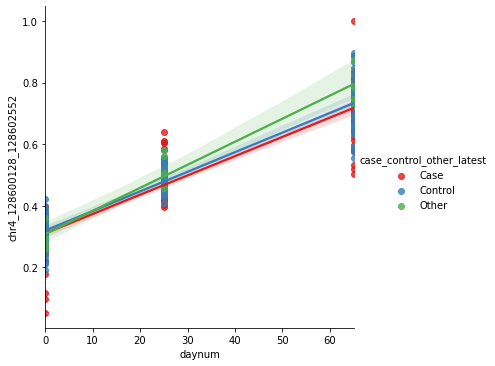

In [31]:
sns.lmplot(x='daynum', y='chr4_128600128_128602552', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

<AxesSubplot:xlabel='daynum', ylabel='chr4_128600128_128602552'>

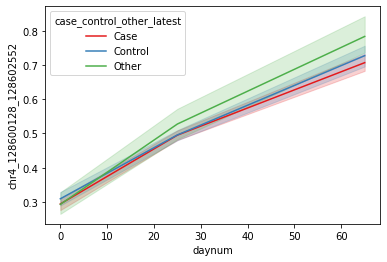

In [41]:
sns.lmplot(x='daynum', y='chr4_128600128_128602552', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

### now re-run everything including Batch, ProliferatingFloorPlateProgenitors and UMAP covariates in the mixed model by subject

#### run the model with extra covariates

In [14]:
print(data_df.shape)
data_df[covs_df.columns].info()

(290, 201721)
<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, ATAC_PPMI18567_da0 to ATAC_PPMI90456_da65
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   x_umap                              290 non-null    float64
 1   y_umap                              290 non-null    float64
 2   sampleid                            290 non-null    object 
 3   cdi                                 290 non-null    int64  
 4   day                                 290 non-null    object 
 5   Batch                               284 non-null    object 
 6   PPMI_ID                             284 non-null    object 
 7   DZNE_Barcode                        284 non-null    object 
 8   DZNE_ID                             284 non-null    float64
 9   Culture_Media_iPSC                  284 non-null    object 
 10  Growth_iPSC                         284 non-null    object 
 11  Spo

In [15]:
# extra covariates are 'Batch', 'ProliferatingFloorPlateProgenitors', some are null remove those rows
data_df = data_df.loc[(~data_df['Batch'].isna()) & 
                      (~data_df['ProliferatingFloorPlateProgenitors'].isna())]
print(data_df.shape)

(284, 201721)


In [18]:
# # test a single model run
# dep_var = 'chr4_128600128_128602552'
# indep_var = 'daynum'
# group_name = 'sampleid'
# this_formula = f'Q("{dep_var}") ~ {indep_var} + Batch + \
# ProliferatingFloorPlateProgenitors + x_umap + y_umap'        
# results = mixed_model(this_formula, data_df, group_name, indep_var)
# print(results)

# model = sm.MixedLM.from_formula(this_formula, data_df, groups=data_df[group_name])
# result = model.fit()
# print(result.summary())

In [16]:
%%time
indep_var = 'daynum'
grouping = 'sampleid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor() as ppe:
# with concurrent.futures.ThreadPoolExecutor() as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, data_df, grouping, True))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

CPU times: user 10.4 s, sys: 12.8 s, total: 23.2 s
Wall time: 3h 9min 41s


In [17]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [18]:
results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(results_df.shape)
display(results_df.head())

(201627, 5)


,feature,coef,stderr,term_cnt,p-value
0,chr1_76145950_76146654,-0.002457,0.000334,10,2.025335e-13
1,chr3_8505594_8506647,0.000486,0.000464,10,2.954291e-01
2,chr8_134619742_134620682,-0.002086,0.000342,10,1.021253e-09
3,chr10_5396446_5397249,0.006076,0.000334,10,6.510279e-74
4,chr2_231780028_231782758,-0.000457,0.000299,10,1.258975e-01


#### calc FDR

In [19]:
# if p-value is NaN, set value to 1
results_df['p-value'].fillna(1, inplace=True)
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201627 entries, 0 to 201626
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   feature   201627 non-null  object 
 1   coef      201627 non-null  float64
 2   stderr    201627 non-null  float64
 3   term_cnt  201627 non-null  int64  
 4   p-value   201627 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.7+ MB


In [20]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(results_df['p-value']),
                                alpha=alpha, method=method)
results_df['bh_fdr'] = test_adjust[1]

print(results_df.loc[results_df['bh_fdr'] < 0.05].shape)
display(results_df.head())

(167372, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,chr1_76145950_76146654,-0.002457,0.000334,10,2.025335e-13,5.092434e-13
1,chr3_8505594_8506647,0.000486,0.000464,10,2.954291e-01,3.230321e-01
2,chr8_134619742_134620682,-0.002086,0.000342,10,1.021253e-09,2.075392e-09
3,chr10_5396446_5397249,0.006076,0.000334,10,6.510279e-74,4.994856e-72
4,chr2_231780028_231782758,-0.000457,0.000299,10,1.258975e-01,1.441195e-01


#### save the discovery cohort results

In [21]:
sig_df = results_df.loc[results_df['bh_fdr'] < 0.05]
display(sig_df.loc[sig_df['p-value'] == min(sig_df['p-value'])])
display(sig_df.loc[sig_df['p-value'] == max(sig_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
80517,chr14_93044594_93046239,-0.005985,0.000202,10,3.071160e-192,6.192288e-187


,feature,coef,stderr,term_cnt,p-value,bh_fdr
147575,chr3_162269321_162270349,0.000802,0.000394,10,0.041501,0.049995


In [22]:
out_file = f'{results_dir}/{cohort}.quants_time_cov_mm.csv'
sig_df.to_csv(out_file, index=False)

#### do some example plotting

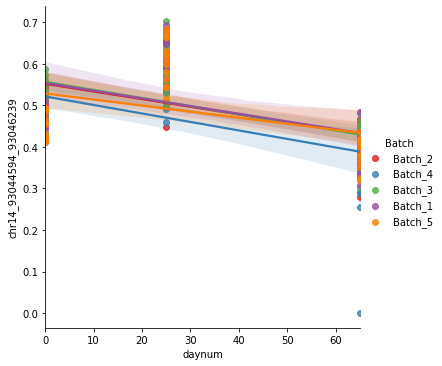

In [43]:
sns.lmplot(x='daynum', y='chr14_93044594_93046239', hue='Batch', 
           data=data_df, palette='Set1')

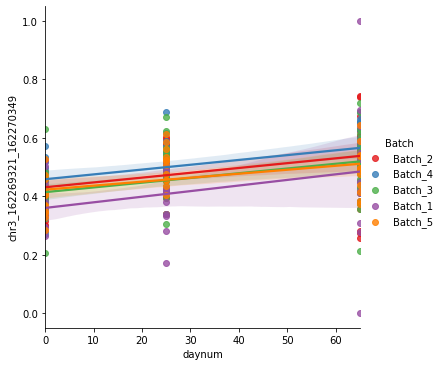

In [44]:
sns.lmplot(x='daynum', y='chr3_162269321_162270349', hue='Batch', 
           data=data_df, palette='Set1')

#### check the replicated mixed model results against the mixed model results also adjusted for age and sex

In [27]:
mm_file = f'{results_dir}/{cohort}.quants_time_mm.csv'
mm_cov_file =  f'{results_dir}/{cohort}.quants_time_cov_mm.csv'
mm_results_df = pd.read_csv(mm_file)
mm_results_df = mm_results_df.loc[mm_results_df['bh_fdr'] < 0.05]
print(mm_results_df.shape)
mm_cov_results_df = pd.read_csv(mm_cov_file)
mm_cov_results_df = mm_cov_results_df.loc[mm_cov_results_df['bh_fdr'] < 0.05]
print(mm_cov_results_df.shape)

(180143, 6)
(167372, 6)


In [28]:
in_both = set(mm_results_df['feature']) & set(mm_cov_results_df['feature'])
print(len(in_both))
in_just_mm = set(mm_results_df['feature']) - set(mm_cov_results_df['feature']) 
print(len(in_just_mm))
in_just_mm_cov = set(mm_cov_results_df['feature']) - set(mm_results_df['feature'])
print(len(in_just_mm_cov))

148729
31414
18643


In [29]:
both_file = f'{results_dir}/{cohort}.quants_time_mm_and_mmcov.csv'
just_mm_file = f'{results_dir}/{cohort}.quants_time_mm_only.csv'
just_mmcov_file = f'{results_dir}/{cohort}.quants_time_mmcov_only.csv'

mm_results_df.loc[mm_results_df['feature'].isin(in_both)].to_csv(both_file, index=False)
mm_results_df.loc[mm_results_df['feature'].isin(in_just_mm)].to_csv(just_mm_file, index=False)
mm_cov_results_df.loc[mm_cov_results_df['feature'].isin(in_just_mm_cov)].to_csv(just_mmcov_file, index=False)

In [30]:
mm_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,chr1_68448392_68449007,-0.002932,0.000198,3,7.660591e-50,3.383531e-49
1,chr15_86163901_86164858,0.003508,0.000175,3,2.065518e-89,2.866631e-88
2,chr19_3585233_3587171,-0.003556,0.000162,3,2.875902e-106,7.082685e-105
3,chr10_86917913_86918670,0.002506,0.000179,3,1.204554e-44,4.627960e-44
4,chr8_23064607_23065520,-0.000567,0.000263,3,3.104999e-02,3.506781e-02


In [31]:
mm_cov_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,chr1_76145950_76146654,-0.002457,0.000334,10,2.025335e-13,5.092434e-13
1,chr8_134619742_134620682,-0.002086,0.000342,10,1.021253e-09,2.075392e-09
2,chr10_5396446_5397249,0.006076,0.000334,10,6.510279e-74,4.994856e-72
3,chr6_50848987_50851834,-0.005036,0.000260,10,7.930344e-84,1.049194e-81
4,chr8_95237930_95239175,-0.004296,0.000326,10,1.561956e-39,1.701694e-38


In [32]:
both_df = mm_results_df.merge(mm_cov_results_df, how='inner', left_on='feature', right_on='feature')
print(both_df.shape)

(148729, 11)


In [33]:
results_df['log10_pvalue'] = np.log10(results_df['p-value'])*-1
results_df['score'] = results_df['coef']/results_df['stderr']

<AxesSubplot:xlabel='coef_x', ylabel='coef_y'>

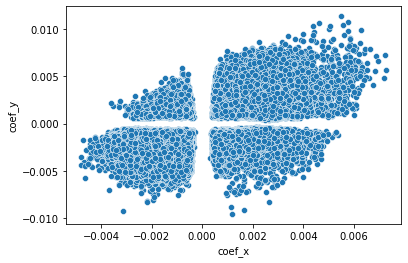

In [34]:
sns.scatterplot(x='coef_x', y='coef_y', data=both_df)

In [35]:
display(both_df.head())

,feature,coef_x,stderr_x,term_cnt_x,p-value_x,bh_fdr_x,coef_y,stderr_y,term_cnt_y,p-value_y,bh_fdr_y
0,chr1_68448392_68449007,-0.002932,0.000198,3,7.660591e-50,3.383531e-49,-0.001149,0.000351,10,1.057407e-03,1.460207e-03
1,chr15_86163901_86164858,0.003508,0.000175,3,2.065518e-89,2.866631e-88,0.003700,0.000323,10,2.281581e-30,1.484872e-29
2,chr19_3585233_3587171,-0.003556,0.000162,3,2.875902e-106,7.082685e-105,-0.002114,0.000277,10,2.358001e-14,6.257639e-14
3,chr10_86917913_86918670,0.002506,0.000179,3,1.204554e-44,4.627960e-44,0.004579,0.000293,10,3.697957e-55,9.815797e-54
4,chr8_23064607_23065520,-0.000567,0.000263,3,3.104999e-02,3.506781e-02,0.002517,0.000429,10,4.592908e-09,8.982533e-09


In [50]:
both_same_dir = both_df.loc[((both_df['coef_x'] > 0) & (both_df['coef_y'] > 0)) | 
                            ((both_df['coef_x'] < 0) & (both_df['coef_y'] < 0))]
print(both_same_dir.shape)
display(both_same_dir.loc[both_same_dir['p-value_y'] == min(both_same_dir['p-value_y'])])
display(both_same_dir.loc[both_same_dir['p-value_y'] == max(both_same_dir['p-value_y'])])

(112024, 11)


,feature,coef_x,stderr_x,term_cnt_x,p-value_x,bh_fdr_x,coef_y,stderr_y,term_cnt_y,p-value_y,bh_fdr_y
12952,chr14_93044594_93046239,-0.0019,0.000201,3,3.427568e-21,6.998099e-21,-0.005985,0.000202,10,3.071160e-192,6.192288e-187


,feature,coef_x,stderr_x,term_cnt_x,p-value_x,bh_fdr_x,coef_y,stderr_y,term_cnt_y,p-value_y,bh_fdr_y
20620,chr3_162269321_162270349,0.001628,0.000215,3,3.863505e-14,6.551064e-14,0.000802,0.000394,10,0.041501,0.049995


#### do some example plotting

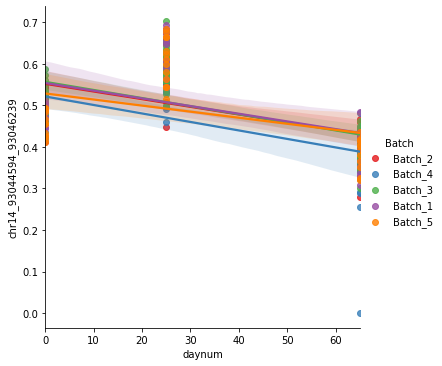

In [51]:
sns.lmplot(x='daynum', y='chr14_93044594_93046239', hue='Batch', 
           data=data_df, palette='Set1')

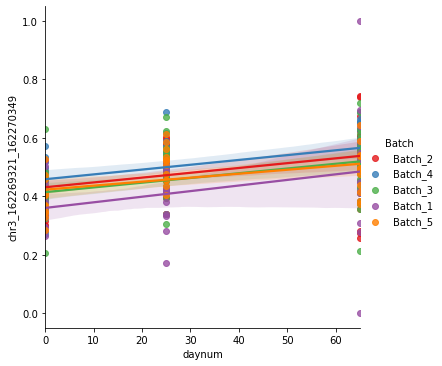

In [52]:
sns.lmplot(x='daynum', y='chr3_162269321_162270349', hue='Batch', 
           data=data_df, palette='Set1')